In [1]:
import sys
sys.path.append('..')

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import imshow
from tqdm import tqdm
import torch
from torch.nn import Module
from torchsummary import summary

from collections import namedtuple, defaultdict
from pathlib import Path
import time

%matplotlib inline
rcParams['figure.figsize'] = (10, 15)

In [3]:
from src.constructor.config_structure import TrainConfigParams
from src.registry import TASKS
from src.constructor.data import create_dataset
from src.constructor.trainer import download_s3_artifact
from train import load_config

In [4]:
def load_hparams(config_path):
    hparams = load_config(config_path)
    hparams = TrainConfigParams(**hparams)
    
    return hparams

In [5]:
config_path = '../configs/leaves_hrnet.yml'
config = load_hparams(config_path)

In [6]:
data_params = config.data
common_params = data_params.common_params
# other_params = data_params.train_params
other_params = data_params.valid_params
# other_params = data_params.test_params
dataset_name = other_params.name

dataset = create_dataset(dataset_name, common_params, other_params)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
# checkpoint = torch.load(download_s3_artifact('s3://ml-fips/mlruns/eedfa4c178bd44f8bc6c44cdcc0f4814/artifacts/last.ckpt', '/tmp'), map_location=device)
checkpoint = torch.load("/workdir/logs/comp-vladvin/2021-11-20_08-25-09/11-311.ckpt")
model = TASKS.get(config.task.name)(config)
model = model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval();
# model.half();

Pretrained weights for hrnet_w18_small will be downloaded


In [9]:
CKPT_PATH = '/workdir/strawberry_hack/checkpoints/leaves_hrnet_w18_small.pt'
HEIGHT, WIDTH = 800, 800

In [10]:
traced = torch.jit.trace(model.forward, torch.rand(2, 3, HEIGHT, WIDTH, device=device))
traced.save(CKPT_PATH)

/opt/conda/envs/torchok/lib/python3.7/site-packages/torch/_jit_internal.py:651: LightningDeprecationWarning: The `LightningModule.datamodule` property is deprecated in v1.3 and will be removed in v1.5. Access the datamodule through using `self.trainer.datamodule` instead.
  if hasattr(mod, name):
/opt/conda/envs/torchok/lib/python3.7/site-packages/torch/_jit_internal.py:651: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):


## Inference

In [11]:
model = torch.jit.load(CKPT_PATH, map_location=device)

In [12]:
from torchvision.transforms import ToTensor, Normalize, Compose

TRANSFORMS = Compose([
    ToTensor(),
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

def longest_max_size(img, max_size=1000):
    if img.shape[0] > img.shape[1]:
        new_h, new_w = max_size, int(max_size / img.shape[0] * img.shape[1])
    else:
        new_h, new_w = int(max_size / img.shape[1] * img.shape[0]), max_size

    img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    return img

def pad_if_needed(img, max_size=1000):
    top = max(0, (max_size - img.shape[0]) // 2)
    bottom = max(0, max_size - img.shape[0] - top)
    left = max(0, (max_size - img.shape[1]) // 2)
    right = max(0, max_size - img.shape[1] - left)
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
    
    return img, top, bottom, left, right

def preprocess(img, max_size=1000):
    img = longest_max_size(img, max_size)
    img, top, bottom, left, right = pad_if_needed(img, max_size)
    tensor = TRANSFORMS(img)
    
    return tensor, top, bottom, left, right

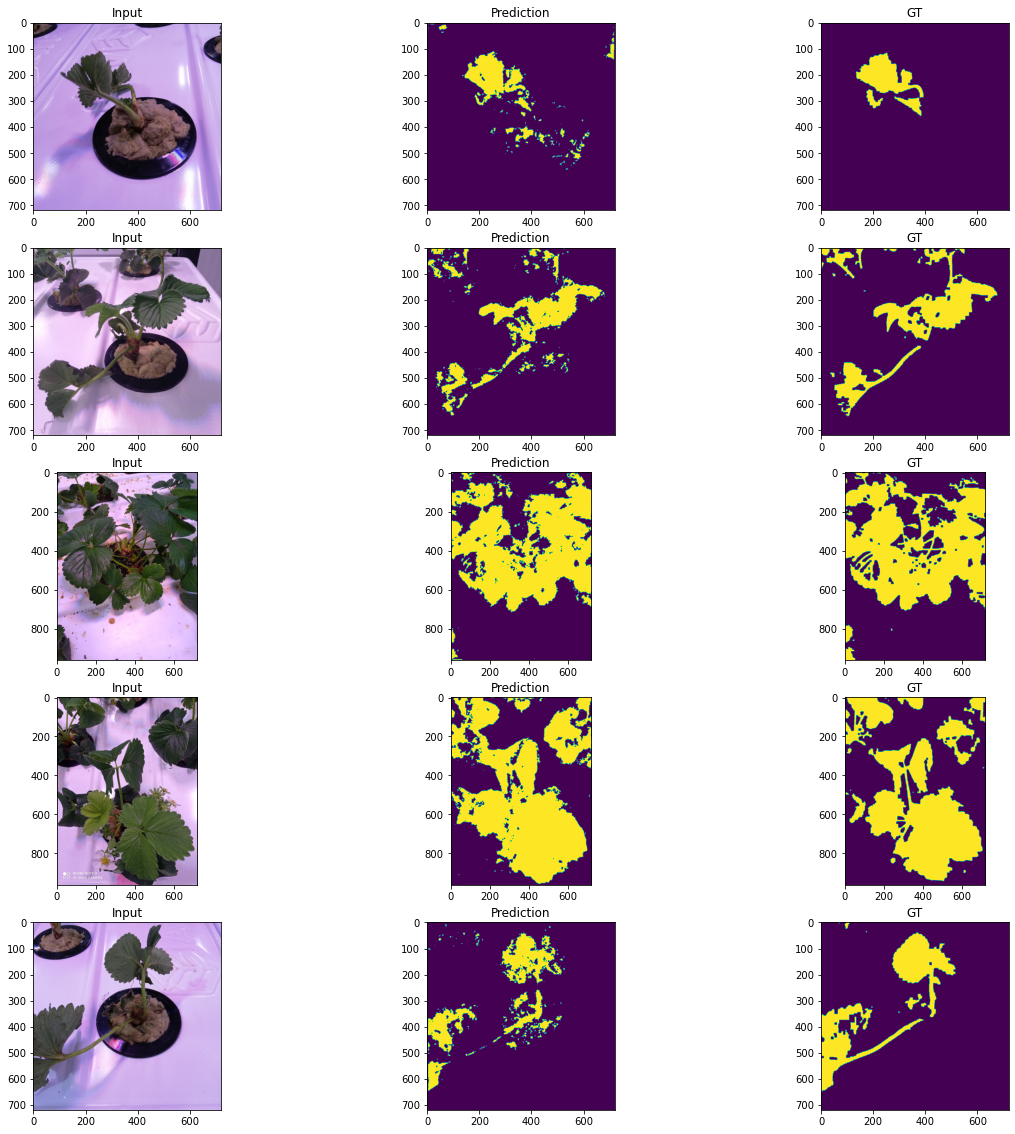

In [13]:
start_idx = 95
n_imgs = 5
fig, axs = plt.subplots(n_imgs, 3, figsize=(20, 4 * n_imgs))

for i in range(n_imgs):
    # Here image is RGB !!!
    img = dataset.read_image(dataset.csv.iloc[start_idx + i])
    mask = dataset.read_mask(dataset.csv.iloc[start_idx + i]['mask_path'])
    tensor, top, bottom, left, right = preprocess(img, max_size=max(HEIGHT, WIDTH))
    
    with torch.no_grad():
        output = model.forward(tensor.to(device).unsqueeze(0)).squeeze(0)
        pred = torch.sigmoid(output)
        pred = pred > 0.5
        pred = (pred * 255).cpu().numpy().astype(np.uint8)
        
    pred = pred[top:, left:]
    if bottom > 0:
        pred = pred[:-bottom, :]
    if right > 0:
        pred = pred[:, :-right]
        
    # Resize mask to initial size
    pred = cv2.resize(pred, img.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)
    
    axs[i][0].imshow(img)
    axs[i][0].set_title('Input')
    
    axs[i][1].imshow(pred)
    axs[i][1].set_title('Prediction')
    
    axs[i][2].imshow(mask)
    axs[i][2].set_title('GT')